In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
import shap
import time
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,roc_curve,auc,roc_auc_score,confusion_matrix
from sklearn.metrics import precision_score,recall_score,f1_score,brier_score_loss,precision_recall_curve
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE,RFECV
import matplotlib.pyplot as plt

In [2]:
os.chdir("/Users/weiyuna/Desktop/工作/合作项目/上海胸科/20211103导出数据/房颤/补充结局-不包含瓣膜手术")

In [3]:
data = pd.read_csv("data_imputation_full.csv")

In [4]:
features_outcome = data.columns[2:5]

In [5]:
features_include = data.columns[5:65]

In [6]:
X = data[features_include]
Y = data[features_outcome]

In [7]:
## 随机拆分训练集和验证集
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=123, stratify=Y)

In [8]:
Y1_train = Y_train["outcome"]
Y2_train = Y_train["outcome_h"]
Y3_train = Y_train["outcome_b"]
Y1_test = Y_test["outcome"]
Y2_test = Y_test["outcome_h"]
Y3_test = Y_test["outcome_b"]

In [9]:
Y1_test.value_counts()

0    991
1     19
Name: outcome, dtype: int64

# 复合结局

In [42]:
xgb_cv_parameters = {'eta':[0.001,0.005,0.01,0.05,0.1], # 5
                     'n_estimators':[50,100,200,300], # 4
                    'max_depth':[3,5,7,10], #4
                     'min_child_weight':[3,5,10,15,20], # 5
                     'colsample_bytree':[0.5,0.7,0.9], # 3
                     'subsample':[0.5,0.7,0.9], # 3
                     'gamma':[0.1],
                     'booster':['gbtree'],
                     'objective':['binary:logistic'],
                     'seed':[123],
                     'nthread':[10]}

st = time.time()
xgb = XGBClassifier()
xgb_gs1 = GridSearchCV(xgb, param_grid = xgb_cv_parameters, cv=3, n_jobs=-1,scoring="roc_auc")
xgb_gs1.fit(X_train,Y1_train)

# 性能测评
print("参数的最佳取值：:", xgb_gs1.best_params_)
print("最佳模型得分:", xgb_gs1.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))

参数的最佳取值：: {'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.005, 'gamma': 0.1, 'max_depth': 10, 'min_child_weight': 3, 'n_estimators': 300, 'nthread': 10, 'objective': 'binary:logistic', 'seed': 123, 'subsample': 0.9}
最佳模型得分: 0.7051581406056115
耗时: 23881.503933906555 s


In [10]:
xgb1 = XGBClassifier(booster="gbtree", colsample_bytree=0.5, eta=0.005, gamma=0.1, max_depth=10,min_child_weight=3,
                     n_estimators=300, nthread=10,objective="binary:logistic",seed=123, subsample=0.9).fit(X_train,Y1_train)

In [11]:
explainer1 = shap.TreeExplainer(xgb1)
shap_values1 = explainer1(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


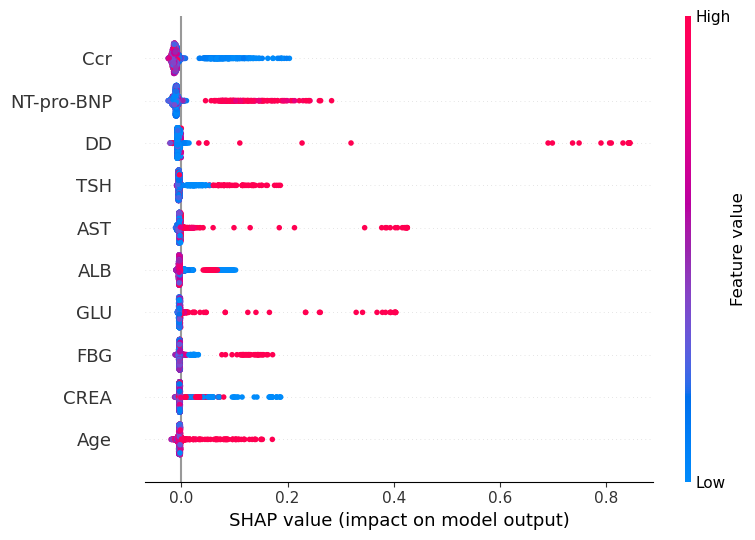

In [12]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values1,X_train,plot_type="dot",max_display=10,show=False)

In [13]:
def get_shap_top_n(shap_value,n):
    fea_imp = pd.DataFrame()
    fea_imp["feature_name"] = X_train.columns
    fea_imp["shap_value"] = np.sum(np.abs(shap_value.values),axis=0)
    fea_imp.sort_values("shap_value",ascending=False,inplace=True)
    return fea_imp[0:n].feature_name.values

In [14]:
def get_shap_values(shap_value):
    fea_imp = pd.DataFrame()
    fea_imp["feature_name"] = X_train.columns
    fea_imp["shap_value"] = np.sum(np.abs(shap_value.values),axis=0)
    fea_imp.sort_values("shap_value",ascending=False,inplace=True)
    return fea_imp

In [15]:
# get_shap_values(shap_values1).to_csv("xgb1_shap.csv")
# get_shap_values(shap_values2).to_csv("xgb2_shap.csv")
# get_shap_values(shap_values3).to_csv("xgb3_shap.csv")

# 心包积液结局

In [47]:
xgb_cv_parameters = {'eta':[0.001,0.005,0.01,0.05,0.1], # 5
                     'n_estimators':[50,100,200,300], # 4
                    'max_depth':[3,5,7,10], #4
                     'min_child_weight':[3,5,10,15,20], # 5
                     'colsample_bytree':[0.5,0.7,0.9], # 3
                     'subsample':[0.5,0.7,0.9], # 3
                     'gamma':[0.1],
                     'booster':['gbtree'],
                     'objective':['binary:logistic'],
                     'seed':[123],
                     'nthread':[10]}

st = time.time()
xgb = XGBClassifier()
xgb_gs2 = GridSearchCV(xgb, param_grid = xgb_cv_parameters, cv=3, n_jobs=-1,scoring="roc_auc")
xgb_gs2.fit(X_train,Y2_train)

# 性能测评
print("参数的最佳取值：:", xgb_gs2.best_params_)
print("最佳模型得分:", xgb_gs2.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))

参数的最佳取值：: {'booster': 'gbtree', 'colsample_bytree': 0.5, 'eta': 0.05, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 15, 'n_estimators': 50, 'nthread': 10, 'objective': 'binary:logistic', 'seed': 123, 'subsample': 0.5}
最佳模型得分: 0.7389654539508844
耗时: 9439.325923919678 s


In [16]:
xgb2 = XGBClassifier(booster="gbtree", colsample_bytree=0.5, eta=0.05, gamma=0.1, max_depth=3,min_child_weight=15,
                     n_estimators=50, nthread=10,objective="binary:logistic",seed=123, subsample=0.5).fit(X_train,Y2_train)

In [17]:
explainer2 = shap.TreeExplainer(xgb2)
shap_values2 = explainer2(X_train)

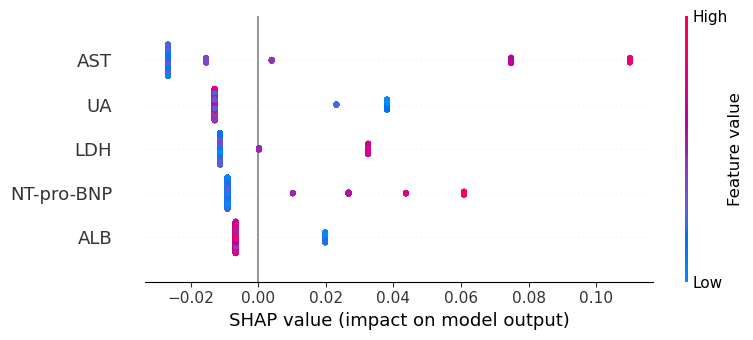

In [18]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values2,X_train,plot_type="dot",max_display=5,show=False)
# plt.savefig("xgb_shap_outcome_h.pdf",dpi=300)

In [20]:
get_shap_top_n(shap_values2,5)

array(['AST', 'UA', 'LDH', 'NT-pro-BNP', 'ALB'], dtype=object)

# 出血结局

In [48]:
xgb_cv_parameters = {'eta':[0.001,0.005,0.01,0.05,0.1], # 5
                     'n_estimators':[50,100,200,300], # 4
                    'max_depth':[3,5,7,10], #4
                     'min_child_weight':[3,5,10,15,20], # 5
                     'colsample_bytree':[0.5,0.7,0.9], # 3
                     'subsample':[0.5,0.7,0.9], # 3
                     'gamma':[0.1],
                     'booster':['gbtree'],
                     'objective':['binary:logistic'],
                     'seed':[123],
                     'nthread':[10]}

st = time.time()
xgb = XGBClassifier()
xgb_gs3 = GridSearchCV(xgb, param_grid = xgb_cv_parameters, cv=3, n_jobs=-1,scoring="roc_auc")
xgb_gs3.fit(X_train,Y3_train)

# 性能测评
print("参数的最佳取值：:", xgb_gs3.best_params_)
print("最佳模型得分:", xgb_gs3.best_score_)
et = time.time()
print("耗时: {} s".format(et-st))

参数的最佳取值：: {'booster': 'gbtree', 'colsample_bytree': 0.9, 'eta': 0.05, 'gamma': 0.1, 'max_depth': 3, 'min_child_weight': 10, 'n_estimators': 100, 'nthread': 10, 'objective': 'binary:logistic', 'seed': 123, 'subsample': 0.9}
最佳模型得分: 0.8080763438053616
耗时: 905.8967139720917 s


In [21]:
xgb3 = XGBClassifier(booster="gbtree", colsample_bytree=0.9, eta=0.05, gamma=0.1, max_depth=3,min_child_weight=10,
                     n_estimators=100, nthread=10,objective="binary:logistic",seed=123, subsample=0.9).fit(X_train,Y3_train)

In [22]:
explainer3 = shap.TreeExplainer(xgb3)
shap_values3 = explainer3(X_train)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


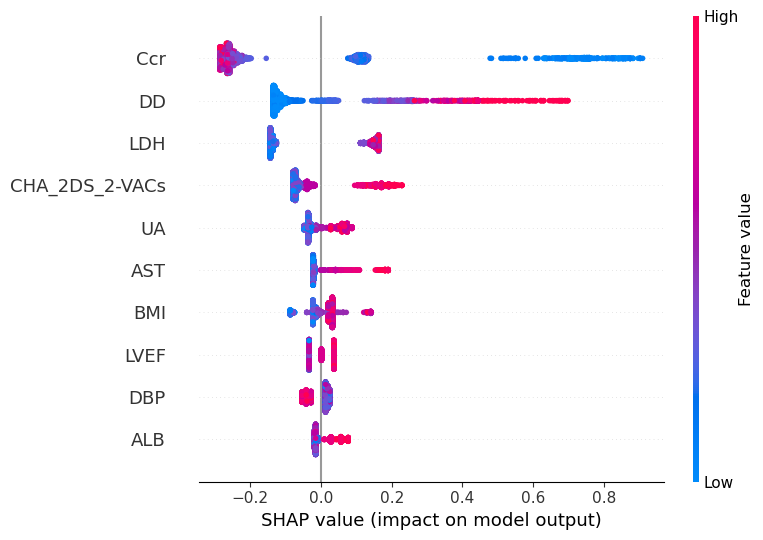

In [23]:
fig = plt.figure(figsize=(10,10))
shap.summary_plot(shap_values3,X_train,plot_type="dot",max_display=10,show=False)

In [25]:
get_shap_top_n(shap_values3,10)

array(['Ccr', 'DD', 'LDH', 'CHA_2DS_2-VACs', 'UA', 'AST', 'BMI', 'LVEF',
       'DBP', 'ALB'], dtype=object)